In [1]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Function to fetch historical stock data from Yahoo Finance
def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

# Function to calculate Moving Average (MA) for a given window
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to add Moving Average as a feature to the dataset
def add_moving_average_feature(data, window):
    data['MA'] = calculate_moving_average(data, window)
    return data

# Function to preprocess data for training the model
def preprocess_data(data, ma_window):
    data = add_moving_average_feature(data, ma_window)
    data['Date'] = data.index
    data['Date'] = pd.to_datetime(data['Date'])
    data['Date'] = data['Date'].dt.date
    data['Date'] = pd.to_datetime(data['Date'])
    data['Date'] = data['Date'].apply(lambda x: x.toordinal())

    # Fill NaN values with 0
    data = data.fillna(0)

    return data

# Function to train a Random Forest Regressor model
def train_model(data):
    X = data[['Date', 'Open', 'High', 'Low', 'Volume', 'MA']]
    y = data['Close']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model, X_test, y_test, scaler

# Function to predict the next day's closing price
def predict_price(model, last_date, scaler, open_price, high_price, low_price, volume):
    next_date = last_date + timedelta(days=1)
    next_date_ordinal = next_date.toordinal()
    input_data = np.array([[next_date_ordinal, open_price, high_price, low_price, volume, 0]])  # 0 is a placeholder for MA since it's not available for the next day
    input_data_scaled = scaler.transform(input_data)
    return model.predict(input_data_scaled)[0]

In [3]:
# Ask user for the ticker symbol
symbol = input("Enter Stock Symbol (e.g., AAPL): ")

# Fetch historical stock data
start_date = datetime(1990, 1, 1)
end_date = datetime.now().date()
stock_data = get_stock_data(symbol, start_date, end_date)

# Preprocess data
ma_window = 20
processed_data = preprocess_data(stock_data, ma_window)

# Train the model
model, X_test, y_test, scaler = train_model(processed_data)


[*********************100%%**********************]  1 of 1 completed


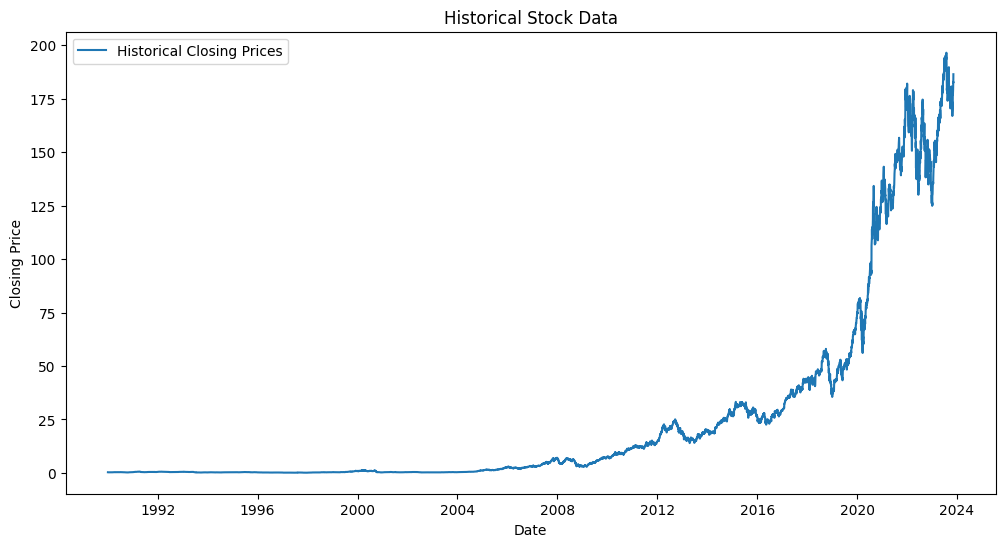

In [4]:
# Plot historical stock data
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Historical Closing Prices')
plt.title('Historical Stock Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

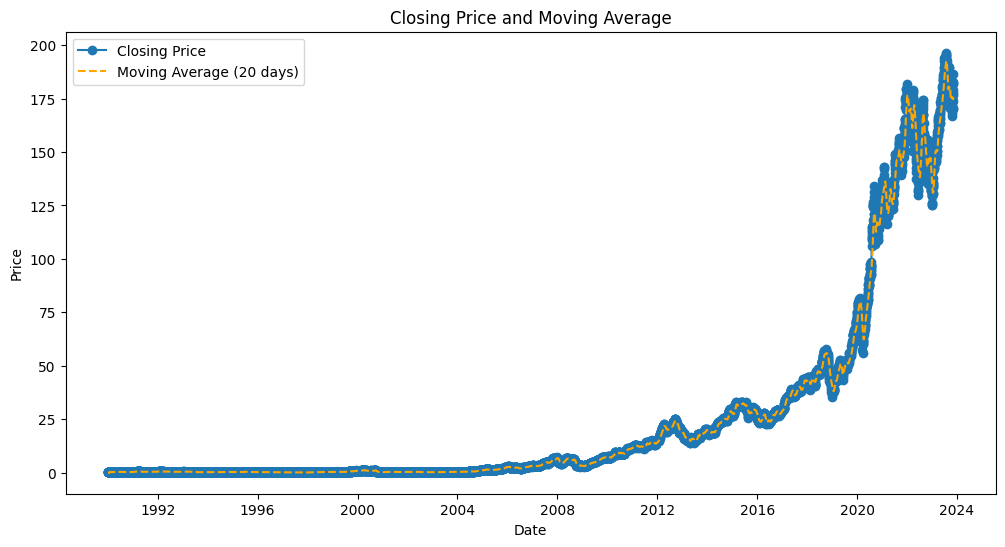

In [5]:
# Plot Moving Average
plt.figure(figsize=(12, 6))
plt.plot(processed_data['Close'], label='Closing Price', linestyle='-')
plt.plot(processed_data['MA'], label=f'Moving Average ({ma_window} days)', linestyle='--', color='orange')
plt.title('Closing Price and Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

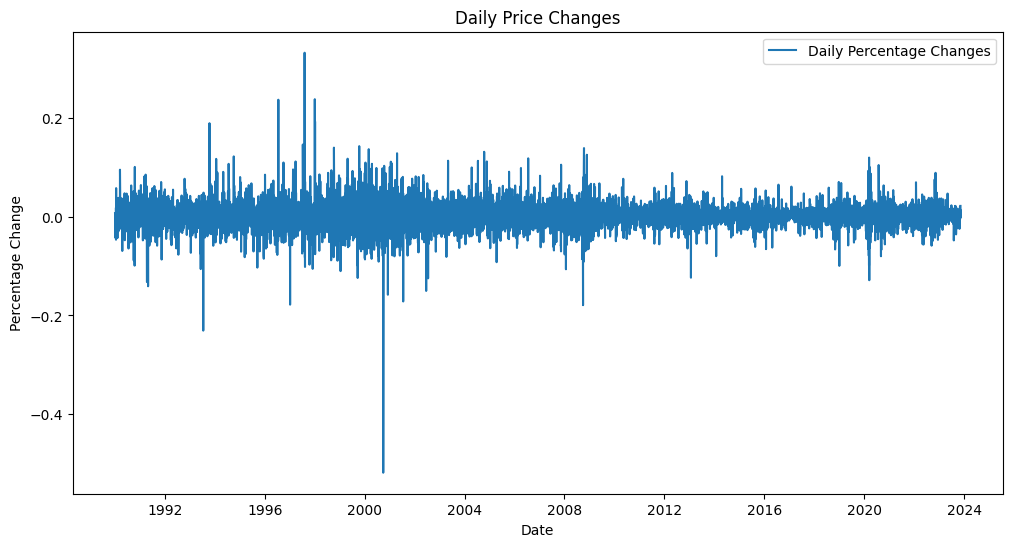

In [6]:
# Plot Daily Price Changes
plt.figure(figsize=(12, 6))
daily_changes = stock_data['Close'].pct_change()
plt.plot(daily_changes, label='Daily Percentage Changes')
plt.title('Daily Price Changes')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

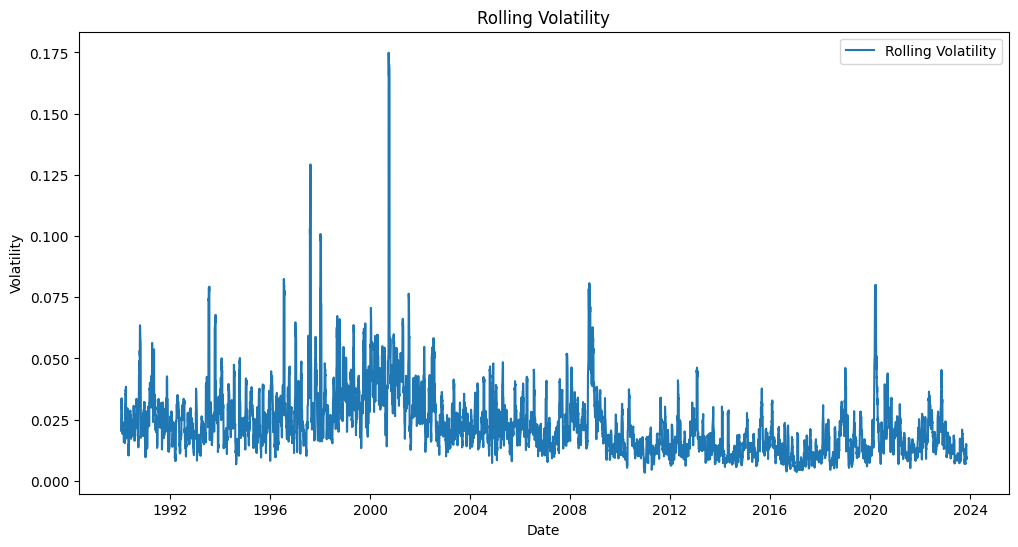

In [7]:
# Plot Rolling Volatility
volatility_window = 10
rolling_volatility = daily_changes.rolling(window=volatility_window).std()

plt.figure(figsize=(12, 6))
plt.plot(rolling_volatility, label='Rolling Volatility')
plt.title('Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [8]:
# Next Day's Predicted Closing Price
last_date = stock_data.index[-1].to_pydatetime().date()
open_price = stock_data['Open'].iloc[-1]
high_price = stock_data['High'].iloc[-1]
low_price = stock_data['Low'].iloc[-1]
volume = stock_data['Volume'].iloc[-1]

next_price = predict_price(model, last_date, scaler, open_price, high_price, low_price, volume)
next_price

186.26919494628908

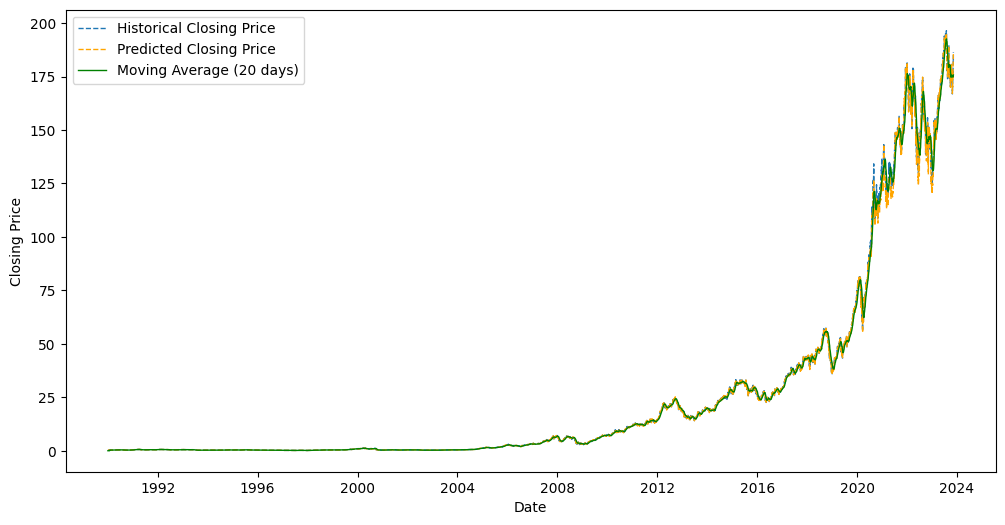

In [9]:
# Actual vs Predicted Closing Prices
plt.figure(figsize=(12, 6))

# Plot historical closing prices
plt.plot(processed_data.index, processed_data['Close'], label='Historical Closing Price', linestyle='--', linewidth=1)

# Plot predicted closing prices
predicted_prices = [predict_price(model, date.date(), scaler, stock_data['Open'].loc[date],
                                  stock_data['High'].loc[date], stock_data['Low'].loc[date],
                                  stock_data['Volume'].loc[date]) for date in processed_data.index]
plt.plot(processed_data.index, predicted_prices, label='Predicted Closing Price', linestyle='--', color='orange', linewidth=1)

# Plot Moving Average
plt.plot(processed_data.index, processed_data['MA'], label=f'Moving Average ({ma_window} days)', linestyle='-', color='green', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()